In [1]:
import os
import wfdb
import pickle

import numpy as np
import heartpy as hp

from math import ceil
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

In [2]:
# https://www.kaggle.com/code/corilei/stress-recognition-in-automobile-driver-1/notebook
# Out[74]

# В работе:
# Rest - отсутствие стресса
# Highway - средний стресс
# City - высокий стресс


# Driver 9
drivers_sessions_info = """
Driver id,Initial Rest,City 1,Highway 1,City 2,Highway 2,City 3,Final Rest,Total duration
Driver05,15.13,16.00,7.74,6.06,7.56,14.96,15.75,83.23
Driver06,15.05,14.49,7.32,6.53,7.64,12.29,15.05,78.38
Driver07,15.04,16.23,10.96,9.83,7.64,10.15,15.03,84.87
Driver08,15.00,12.31,7.23,9.51,7.64,13.43,15.07,80.19
Driver09,15.66,19.21,8.47,5.20,7.06,13.21,0.00,68.82
Driver10,15.04,15.30,8.66,5.27,7.04,12.06,14.79,78.15
Driver11,15.02,15.81,7.43,7.15,6.96,11.72,14.99,79.08
Driver12,15.01,13.41,7.56,6.50,8.06,11.68,15.01,77.23
Driver15,15.00,12.54,7.24,5.99,6.82,12.12,15.00,74.70
Driver16,15.01,16.12,7.14,5.12,6.81,13.91,0.00,64.10
"""

drivers_sessions_info = list(
    map(
        lambda x: x.split(","),
        filter(bool, drivers_sessions_info.splitlines()),
    )
)
titles = drivers_sessions_info[0][1:]
drivers_sessions_info = drivers_sessions_info[1:]
drivers_sessions_info = {
    int(el[0][6:]): list(map(float, el[1:])) for el in drivers_sessions_info
}
drivers_sessions_info = {
    key: dict(zip(titles, val)) for key, val in drivers_sessions_info.items()
}

In [3]:
sum(map(lambda x: x.get("Total duration"), drivers_sessions_info.values()))

768.7500000000001

In [4]:
excluded_ranges = {
    5: [(29000, 34000)],
    7: [(82400, -1)],
    8: [(75400, -1)],
    9: [(65800, -1)],
}

# 0 - no stress
# 1 - medium stress
# 2 - high stress
action_stress_level_mapping = {
    "Initial Rest": 0,
    "City 1": 2,
    "Highway 1": 1,
    "City 2": 2,
    "Highway 2": 1,
    "City 3": 2,
    "Final Rest": 0,
}

In [5]:
# delta of total duration and sum of all other steps
{
    u_id: round(
        sum(list(timest.values())[:-1]) - timest.get("Total duration"), 3
    )
    for u_id, timest in drivers_sessions_info.items()
}

{5: -0.03,
 6: -0.01,
 7: 0.01,
 8: 0.0,
 9: -0.01,
 10: 0.01,
 11: 0.0,
 12: 0.0,
 15: 0.01,
 16: 0.01}

In [6]:
records = {
    u: wfdb.rdrecord(
        os.path.join(
            "data",
            "stress-recognition-in-automobile-drivers",
            "data",
            f"drive{str(u).zfill(2)}",
        )
    )
    for u in drivers_sessions_info.keys()
}

In [7]:
drivers_sessions_info

{5: {'Initial Rest': 15.13,
  'City 1': 16.0,
  'Highway 1': 7.74,
  'City 2': 6.06,
  'Highway 2': 7.56,
  'City 3': 14.96,
  'Final Rest': 15.75,
  'Total duration': 83.23},
 6: {'Initial Rest': 15.05,
  'City 1': 14.49,
  'Highway 1': 7.32,
  'City 2': 6.53,
  'Highway 2': 7.64,
  'City 3': 12.29,
  'Final Rest': 15.05,
  'Total duration': 78.38},
 7: {'Initial Rest': 15.04,
  'City 1': 16.23,
  'Highway 1': 10.96,
  'City 2': 9.83,
  'Highway 2': 7.64,
  'City 3': 10.15,
  'Final Rest': 15.03,
  'Total duration': 84.87},
 8: {'Initial Rest': 15.0,
  'City 1': 12.31,
  'Highway 1': 7.23,
  'City 2': 9.51,
  'Highway 2': 7.64,
  'City 3': 13.43,
  'Final Rest': 15.07,
  'Total duration': 80.19},
 9: {'Initial Rest': 15.66,
  'City 1': 19.21,
  'Highway 1': 8.47,
  'City 2': 5.2,
  'Highway 2': 7.06,
  'City 3': 13.21,
  'Final Rest': 0.0,
  'Total duration': 68.82},
 10: {'Initial Rest': 15.04,
  'City 1': 15.3,
  'Highway 1': 8.66,
  'City 2': 5.27,
  'Highway 2': 7.04,
  'City 3': 

In [9]:
# time diff (in sec) between signals length and time duration in table
{
    u_id: records.get(u_id).sig_len / 15.5 - timest.get("Total duration") * 60
    for u_id, timest in drivers_sessions_info.items()
}

{5: 62.13548387096762,
 6: 143.84516129032363,
 7: 226.63870967741877,
 8: 60.14838709677497,
 9: 123.18709677419338,
 10: 187.9032258064517,
 11: 128.29677419354812,
 12: 350.5225806451608,
 15: 176.6451612903229,
 16: 51.935483870968255}

In [ ]:
requested_fields = ("fs", "sig_len", "sig_name", "p_signal")
records = {
    u_id: {
        v_name: v_value
        for v_name, v_value in val.__dict__.items()
        if v_name in requested_fields
    }
    for u_id, val in records.items()
}

In [ ]:
# # apply savgol filter
# for u_id, val in records.items():
#     raw = val.get("p_signal")
#     print(u_id)
#     filtered = savgol_filter(raw, 30, 10)
#     val.update(
#         {
#             "raw": raw,
#             "p_signal": filtered,
#         }
#     )

In [13]:
time_shift_for_ranges = {
    driver_id: ceil(
        (
            records.get(driver_id).get("sig_len")
            - drivers_sessions_info.get(driver_id).get("Total duration")
            * 15.5
            * 60
        )
        / 2
    )
    for driver_id in records
}
time_shift_for_ranges

{5: 482,
 6: 1115,
 7: 1757,
 8: 467,
 9: 955,
 10: 1457,
 11: 995,
 12: 2717,
 15: 1369,
 16: 403}

In [14]:
for u_id, data in records.items():
    print(
        f"User {u_id}; rate: {data.get('fs')}; signals: {data.get('sig_name')}"
    )

User 5; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP']
User 6; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP']
User 7; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSr', 'HR', 'marker', 'RESP']
User 8; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP']
User 9; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP']
User 10; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP']
User 11; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP']
User 12; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP']
User 15; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP']
User 16; rate: 15.5; signals: ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP']


In [15]:
def mean_std_plt(user_id, full_range):
    record = records.get(user_id)
    wd, m = hp.process(record.get("p_signal")[full_range, 0], record.get("fs"))
    mean, std = np.mean(wd.get("RR_list_cor")), np.std(wd.get("RR_list_cor"))
    plot = hp.plotter(wd, m, figsize=(20, 6), show=False)
    return mean, std, plot

In [16]:
record = records.get(5)
wd, m = hp.process(record.get("p_signal")[:500, 0], record.get("fs"))
mean, std = np.mean(wd.get("RR_list_cor")), np.std(wd.get("RR_list_cor"))

In [17]:
def get_indices_of_subtasks(driver_id):
    indices_of_subtasks = np.ceil(
        np.fromiter(drivers_sessions_info.get(driver_id).values(), dtype=float)
        * 15.5
        * 60
    ).astype(int)
    indices_of_subtasks[-1] = 0
    indices_of_subtasks = np.cumsum(np.roll(indices_of_subtasks, 1))
    delta = time_shift_for_ranges.get(driver_id)
    ranges = np.vstack((indices_of_subtasks[:-1], indices_of_subtasks[1:])).T
    # don't add if task duration == 0
    add_mask = np.ravel(np.diff(ranges, axis=1).astype(bool))
    ranges[add_mask] += np.array([1, -1]) * delta
    return ranges

In [18]:
driver_id = 16
indices_of_subtasks = np.ceil(
    np.fromiter(drivers_sessions_info.get(driver_id).values(), dtype=float)
    * 15.5
    * 60
).astype(int)
indices_of_subtasks[-1] = 0
indices_of_subtasks = np.cumsum(np.roll(indices_of_subtasks, 1))
delta = time_shift_for_ranges.get(driver_id)
ranges = np.vstack((indices_of_subtasks[:-1], indices_of_subtasks[1:])).T

# don't add if task duration == 0
add_mask = np.ravel(np.diff(ranges, axis=1).astype(bool))
ranges[add_mask] += np.array([1, -1]) * delta
print(ranges)

[[  403 13557]
 [14363 28549]
 [29355 35190]
 [35996 39952]
 [40758 46286]
 [47092 59223]
 [59626 59626]]


In [19]:
# проверка данных на возможность обработки
# в 9 и 16 отсутствуют финальные сессии отдыха
# в 5 в диапазоне 29000-36150 есть потеря данных
if False:
    for driver_id in records.keys():
        record = records.get(driver_id)
        failed = []
        for range_ in get_indices_of_subtasks(driver_id):
            try:
                wd, m = hp.process(
                    record.get("p_signal")[range_[0] : range_[1], 0],
                    record.get("fs"),
                )
                mean, std = np.mean(wd.get("RR_list_cor")), np.std(
                    wd.get("RR_list_cor")
                )
                # print(range_, mean, std)
            except Exception as e:
                print(driver_id, range_, "failed to be processed")

---

In [20]:
excluded_ranges = {
    5: [(29000, 34000)],
    7: [(82400, 82442)],
    8: [(75400, 75509)],
    9: [(65800, 65912)],
}

In [21]:
drivers_sessions_stress_ranges = {
    driver_id: dict(
        zip(
            map(tuple, get_indices_of_subtasks(driver_id)),
            map(lambda x: action_stress_level_mapping.get(x), sessions.keys()),
        )
    )
    for driver_id, sessions in drivers_sessions_info.items()
}

In [22]:
from copy import deepcopy

# remove strange signals parts
cleared_drivers_sessions_stress_ranges = deepcopy(
    drivers_sessions_stress_ranges
)
for driver_id, driver_excluded_ranges in excluded_ranges.items():
    driver_sessions = drivers_sessions_stress_ranges.get(driver_id)
    new_driver_sessions = deepcopy(driver_sessions)
    for ex_left_bound, ex_right_bound in driver_excluded_ranges:
        for (l, r), v in driver_sessions.items():
            if l >= ex_left_bound and r < ex_right_bound:
                # зона полностью входит в исключаемый диапазон
                new_driver_sessions.pop((l, r), None)
                continue
            if l <= ex_left_bound < r:
                new_driver_sessions.pop((l, r), None)
                if l < ex_left_bound:
                    new_driver_sessions.update({(l, ex_left_bound): v})
            if l <= ex_right_bound < r:
                new_driver_sessions.pop((l, r), None)
                if ex_right_bound < r:
                    new_driver_sessions.update({(ex_right_bound, r): v})
    cleared_drivers_sessions_stress_ranges.update(
        {driver_id: new_driver_sessions}
    )

In [23]:
drivers_sessions_stress_ranges

{5: {(482, 13589): 0,
  (14553, 28469): 2,
  (29433, 35668): 1,
  (36632, 41304): 2,
  (42268, 48335): 1,
  (49299, 62248): 2,
  (63212, 76896): 0},
 6: {(1115, 12882): 0,
  (15112, 26358): 2,
  (28588, 33166): 1,
  (35396, 39239): 2,
  (41469, 46345): 1,
  (48575, 57775): 2,
  (60005, 71772): 0},
 7: {(1757, 12231): 0,
  (15745, 27325): 2,
  (30839, 37518): 1,
  (41032, 46660): 2,
  (50174, 53766): 1,
  (57280, 63206): 2,
  (66720, 77184): 0},
 8: {(467, 13483): 0,
  (14417, 24932): 2,
  (25866, 31656): 1,
  (32590, 40501): 2,
  (41435, 47607): 1,
  (48541, 60097): 2,
  (61031, 74113): 0},
 9: {(955, 13609): 0,
  (15519, 31475): 2,
  (33385, 39353): 1,
  (41263, 44190): 2,
  (46100, 50756): 1,
  (52666, 63042): 2,
  (63997, 63997): 0},
 10: {(1457, 12531): 0,
  (15445, 26760): 2,
  (29674, 34814): 1,
  (37728, 39716): 2,
  (42630, 46264): 1,
  (49178, 57480): 2,
  (60394, 71235): 0},
 11: {(995, 12974): 0,
  (14964, 27678): 2,
  (29668, 34588): 1,
  (36578, 41238): 2,
  (43228, 47711)

In [24]:
cleared_drivers_sessions_stress_ranges

{5: {(482, 13589): 0,
  (14553, 28469): 2,
  (36632, 41304): 2,
  (42268, 48335): 1,
  (49299, 62248): 2,
  (63212, 76896): 0,
  (34000, 35668): 1},
 6: {(1115, 12882): 0,
  (15112, 26358): 2,
  (28588, 33166): 1,
  (35396, 39239): 2,
  (41469, 46345): 1,
  (48575, 57775): 2,
  (60005, 71772): 0},
 7: {(1757, 12231): 0,
  (15745, 27325): 2,
  (30839, 37518): 1,
  (41032, 46660): 2,
  (50174, 53766): 1,
  (57280, 63206): 2,
  (66720, 77184): 0},
 8: {(467, 13483): 0,
  (14417, 24932): 2,
  (25866, 31656): 1,
  (32590, 40501): 2,
  (41435, 47607): 1,
  (48541, 60097): 2,
  (61031, 74113): 0},
 9: {(955, 13609): 0,
  (15519, 31475): 2,
  (33385, 39353): 1,
  (41263, 44190): 2,
  (46100, 50756): 1,
  (52666, 63042): 2,
  (63997, 63997): 0},
 10: {(1457, 12531): 0,
  (15445, 26760): 2,
  (29674, 34814): 1,
  (37728, 39716): 2,
  (42630, 46264): 1,
  (49178, 57480): 2,
  (60394, 71235): 0},
 11: {(995, 12974): 0,
  (14964, 27678): 2,
  (29668, 34588): 1,
  (36578, 41238): 2,
  (43228, 47711)

---

In [25]:
cleared_drivers_sessions_stress_ranges

{5: {(482, 13589): 0,
  (14553, 28469): 2,
  (36632, 41304): 2,
  (42268, 48335): 1,
  (49299, 62248): 2,
  (63212, 76896): 0,
  (34000, 35668): 1},
 6: {(1115, 12882): 0,
  (15112, 26358): 2,
  (28588, 33166): 1,
  (35396, 39239): 2,
  (41469, 46345): 1,
  (48575, 57775): 2,
  (60005, 71772): 0},
 7: {(1757, 12231): 0,
  (15745, 27325): 2,
  (30839, 37518): 1,
  (41032, 46660): 2,
  (50174, 53766): 1,
  (57280, 63206): 2,
  (66720, 77184): 0},
 8: {(467, 13483): 0,
  (14417, 24932): 2,
  (25866, 31656): 1,
  (32590, 40501): 2,
  (41435, 47607): 1,
  (48541, 60097): 2,
  (61031, 74113): 0},
 9: {(955, 13609): 0,
  (15519, 31475): 2,
  (33385, 39353): 1,
  (41263, 44190): 2,
  (46100, 50756): 1,
  (52666, 63042): 2,
  (63997, 63997): 0},
 10: {(1457, 12531): 0,
  (15445, 26760): 2,
  (29674, 34814): 1,
  (37728, 39716): 2,
  (42630, 46264): 1,
  (49178, 57480): 2,
  (60394, 71235): 0},
 11: {(995, 12974): 0,
  (14964, 27678): 2,
  (29668, 34588): 1,
  (36578, 41238): 2,
  (43228, 47711)

In [26]:
# Initial Rest,City 1,Highway 1,City 2,Highway 2,City 3,Final Rest
result_dict = {}
for driver_id, record in records.items():
    print("Driver", driver_id)
    driver_list = []
    for range_, stress_label in cleared_drivers_sessions_stress_ranges.get(
        driver_id
    ).items():
        if range_[1] - range_[0]:
            try:
                ecg_signal = record.get("p_signal")[range_[0] : range_[1], 0]
                filtered = savgol_filter(ecg_signal, 30, 10)
                fs = record.get("fs")
                wd, m = hp.process(ecg_signal, fs)
                # mean, std = np.mean(wd.get("RR_list_cor")), np.std(wd.get("RR_list_cor"))
                driver_list.append(
                    {
                        "stress_label": stress_label,
                        "ECG_signal": ecg_signal,
                        "filtered_ECG_signal": filtered,
                        "original_range": range_,
                        "fs": fs,
                        "working_data": wd,
                        "measurements": m,
                    }
                )
                print(range_, mean, std)
            except Exception as e:
                print(range_, "failed to be proccesed")
    result_dict.update({driver_id: driver_list})

Driver 5
(482, 13589) 393.54838709677426 185.3084724689687
(14553, 28469) 393.54838709677426 185.3084724689687
(36632, 41304) 393.54838709677426 185.3084724689687
(42268, 48335) 393.54838709677426 185.3084724689687
(49299, 62248) 393.54838709677426 185.3084724689687
(63212, 76896) 393.54838709677426 185.3084724689687
(34000, 35668) 393.54838709677426 185.3084724689687
Driver 6
(1115, 12882) 393.54838709677426 185.3084724689687
(15112, 26358) 393.54838709677426 185.3084724689687
(28588, 33166) 393.54838709677426 185.3084724689687
(35396, 39239) 393.54838709677426 185.3084724689687
(41469, 46345) 393.54838709677426 185.3084724689687
(48575, 57775) 393.54838709677426 185.3084724689687
(60005, 71772) 393.54838709677426 185.3084724689687
Driver 7


/home/dmo/Documents/human_func_state/venv/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


(1757, 12231) 393.54838709677426 185.3084724689687
(15745, 27325) 393.54838709677426 185.3084724689687
(30839, 37518) 393.54838709677426 185.3084724689687
(41032, 46660) 393.54838709677426 185.3084724689687
(50174, 53766) 393.54838709677426 185.3084724689687
(57280, 63206) 393.54838709677426 185.3084724689687
(66720, 77184) 393.54838709677426 185.3084724689687
Driver 8
(467, 13483) 393.54838709677426 185.3084724689687
(14417, 24932) 393.54838709677426 185.3084724689687
(25866, 31656) 393.54838709677426 185.3084724689687
(32590, 40501) 393.54838709677426 185.3084724689687
(41435, 47607) 393.54838709677426 185.3084724689687
(48541, 60097) 393.54838709677426 185.3084724689687
(61031, 74113) 393.54838709677426 185.3084724689687
Driver 9
(955, 13609) 393.54838709677426 185.3084724689687
(15519, 31475) 393.54838709677426 185.3084724689687
(33385, 39353) 393.54838709677426 185.3084724689687
(41263, 44190) 393.54838709677426 185.3084724689687
(46100, 50756) 393.54838709677426 185.3084724689687

In [74]:
len(result_dict.get(5)), result_dict.get(5)[0].keys()

(7,
 dict_keys(['stress_label', 'ECG_signal', 'original_range', 'fs', 'working_data', 'measurements']))

In [75]:
import pickle

with open("cleared_drivers_session_info.pkl", "wb") as f:
    pickle.dump(result_dict, f)

In [76]:
all_sessions = [
    item
    for sublist in list(
        map(list, map(dict.items, list(drivers_sessions_info.values())))
    )
    for item in sublist
]

In [128]:
all_sessions

[('Initial Rest', 15.13),
 ('City 1', 16.0),
 ('Highway 1', 7.74),
 ('City 2', 6.06),
 ('Highway 2', 7.56),
 ('City 3', 14.96),
 ('Final Rest', 15.75),
 ('Total duration', 83.23),
 ('Initial Rest', 15.05),
 ('City 1', 14.49),
 ('Highway 1', 7.32),
 ('City 2', 6.53),
 ('Highway 2', 7.64),
 ('City 3', 12.29),
 ('Final Rest', 15.05),
 ('Total duration', 78.38),
 ('Initial Rest', 15.04),
 ('City 1', 16.23),
 ('Highway 1', 10.96),
 ('City 2', 9.83),
 ('Highway 2', 7.64),
 ('City 3', 10.15),
 ('Final Rest', 15.03),
 ('Total duration', 84.87),
 ('Initial Rest', 15.0),
 ('City 1', 12.31),
 ('Highway 1', 7.23),
 ('City 2', 9.51),
 ('Highway 2', 7.64),
 ('City 3', 13.43),
 ('Final Rest', 15.07),
 ('Total duration', 80.19),
 ('Initial Rest', 15.66),
 ('City 1', 19.21),
 ('Highway 1', 8.47),
 ('City 2', 5.2),
 ('Highway 2', 7.06),
 ('City 3', 13.21),
 ('Final Rest', 0.0),
 ('Total duration', 68.82),
 ('Initial Rest', 15.04),
 ('City 1', 15.3),
 ('Highway 1', 8.66),
 ('City 2', 5.27),
 ('Highway 2'

In [37]:
common_rest_len = sum(
    map(lambda x: x[1], (filter(lambda x: "Rest" in x[0], all_sessions)))
)
common_stress_len = sum(
    map(lambda x: x[1], (filter(lambda x: "Rest" not in x[0], all_sessions)))
)
common_rest_len, common_stress_len  # minutes

(271.65, 1265.8399999999992)

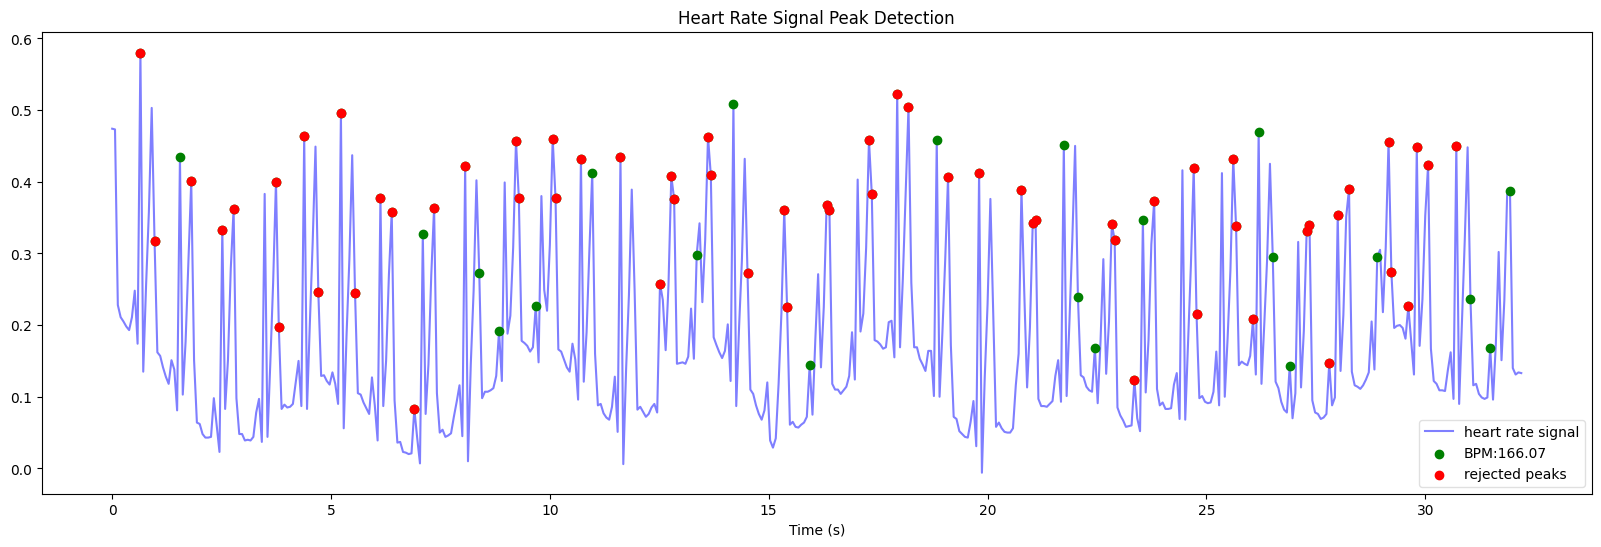

In [101]:
r = hp.process(
    result_dict.get(5)[0].get("ECG_signal")[2000:2500],
    sample_rate=15.5,
    clean_rr=True,
)
hp.plotter(r[0], r[1], figsize=(20, 6))

In [81]:
import scipy.signal as signal

In [82]:
signal.find_peaks(records.get(5).get("p_signal")[:500, 0])

(array([  1,   3,   7,  11,  14,  17,  21,  24,  27,  31,  34,  37,  41,
         43,  47,  51,  54,  57,  63,  66,  70,  78,  82,  85,  89,  91,
         95,  98, 101, 104, 107, 113, 116, 119, 125, 128, 131, 134, 137,
        140, 143, 146, 148, 151, 154, 160, 162, 166, 169, 172, 174, 178,
        181, 184, 187, 190, 197, 200, 203, 206, 209, 212, 215, 220, 223,
        226, 231, 233, 237, 240, 243, 245, 249, 252, 255, 258, 261, 268,
        271, 275, 282, 284, 288, 291, 295, 298, 302, 309, 312, 315, 322,
        325, 328, 331, 334, 337, 340, 347, 350, 353, 356, 360, 363, 367,
        370, 376, 380, 383, 387, 390, 393, 396, 399, 402, 405, 412, 414,
        418, 421, 425, 427, 431, 434, 437, 440, 444, 450, 453, 456, 459,
        462, 465, 468, 475, 478, 482, 485, 490, 492, 496]),
 {})

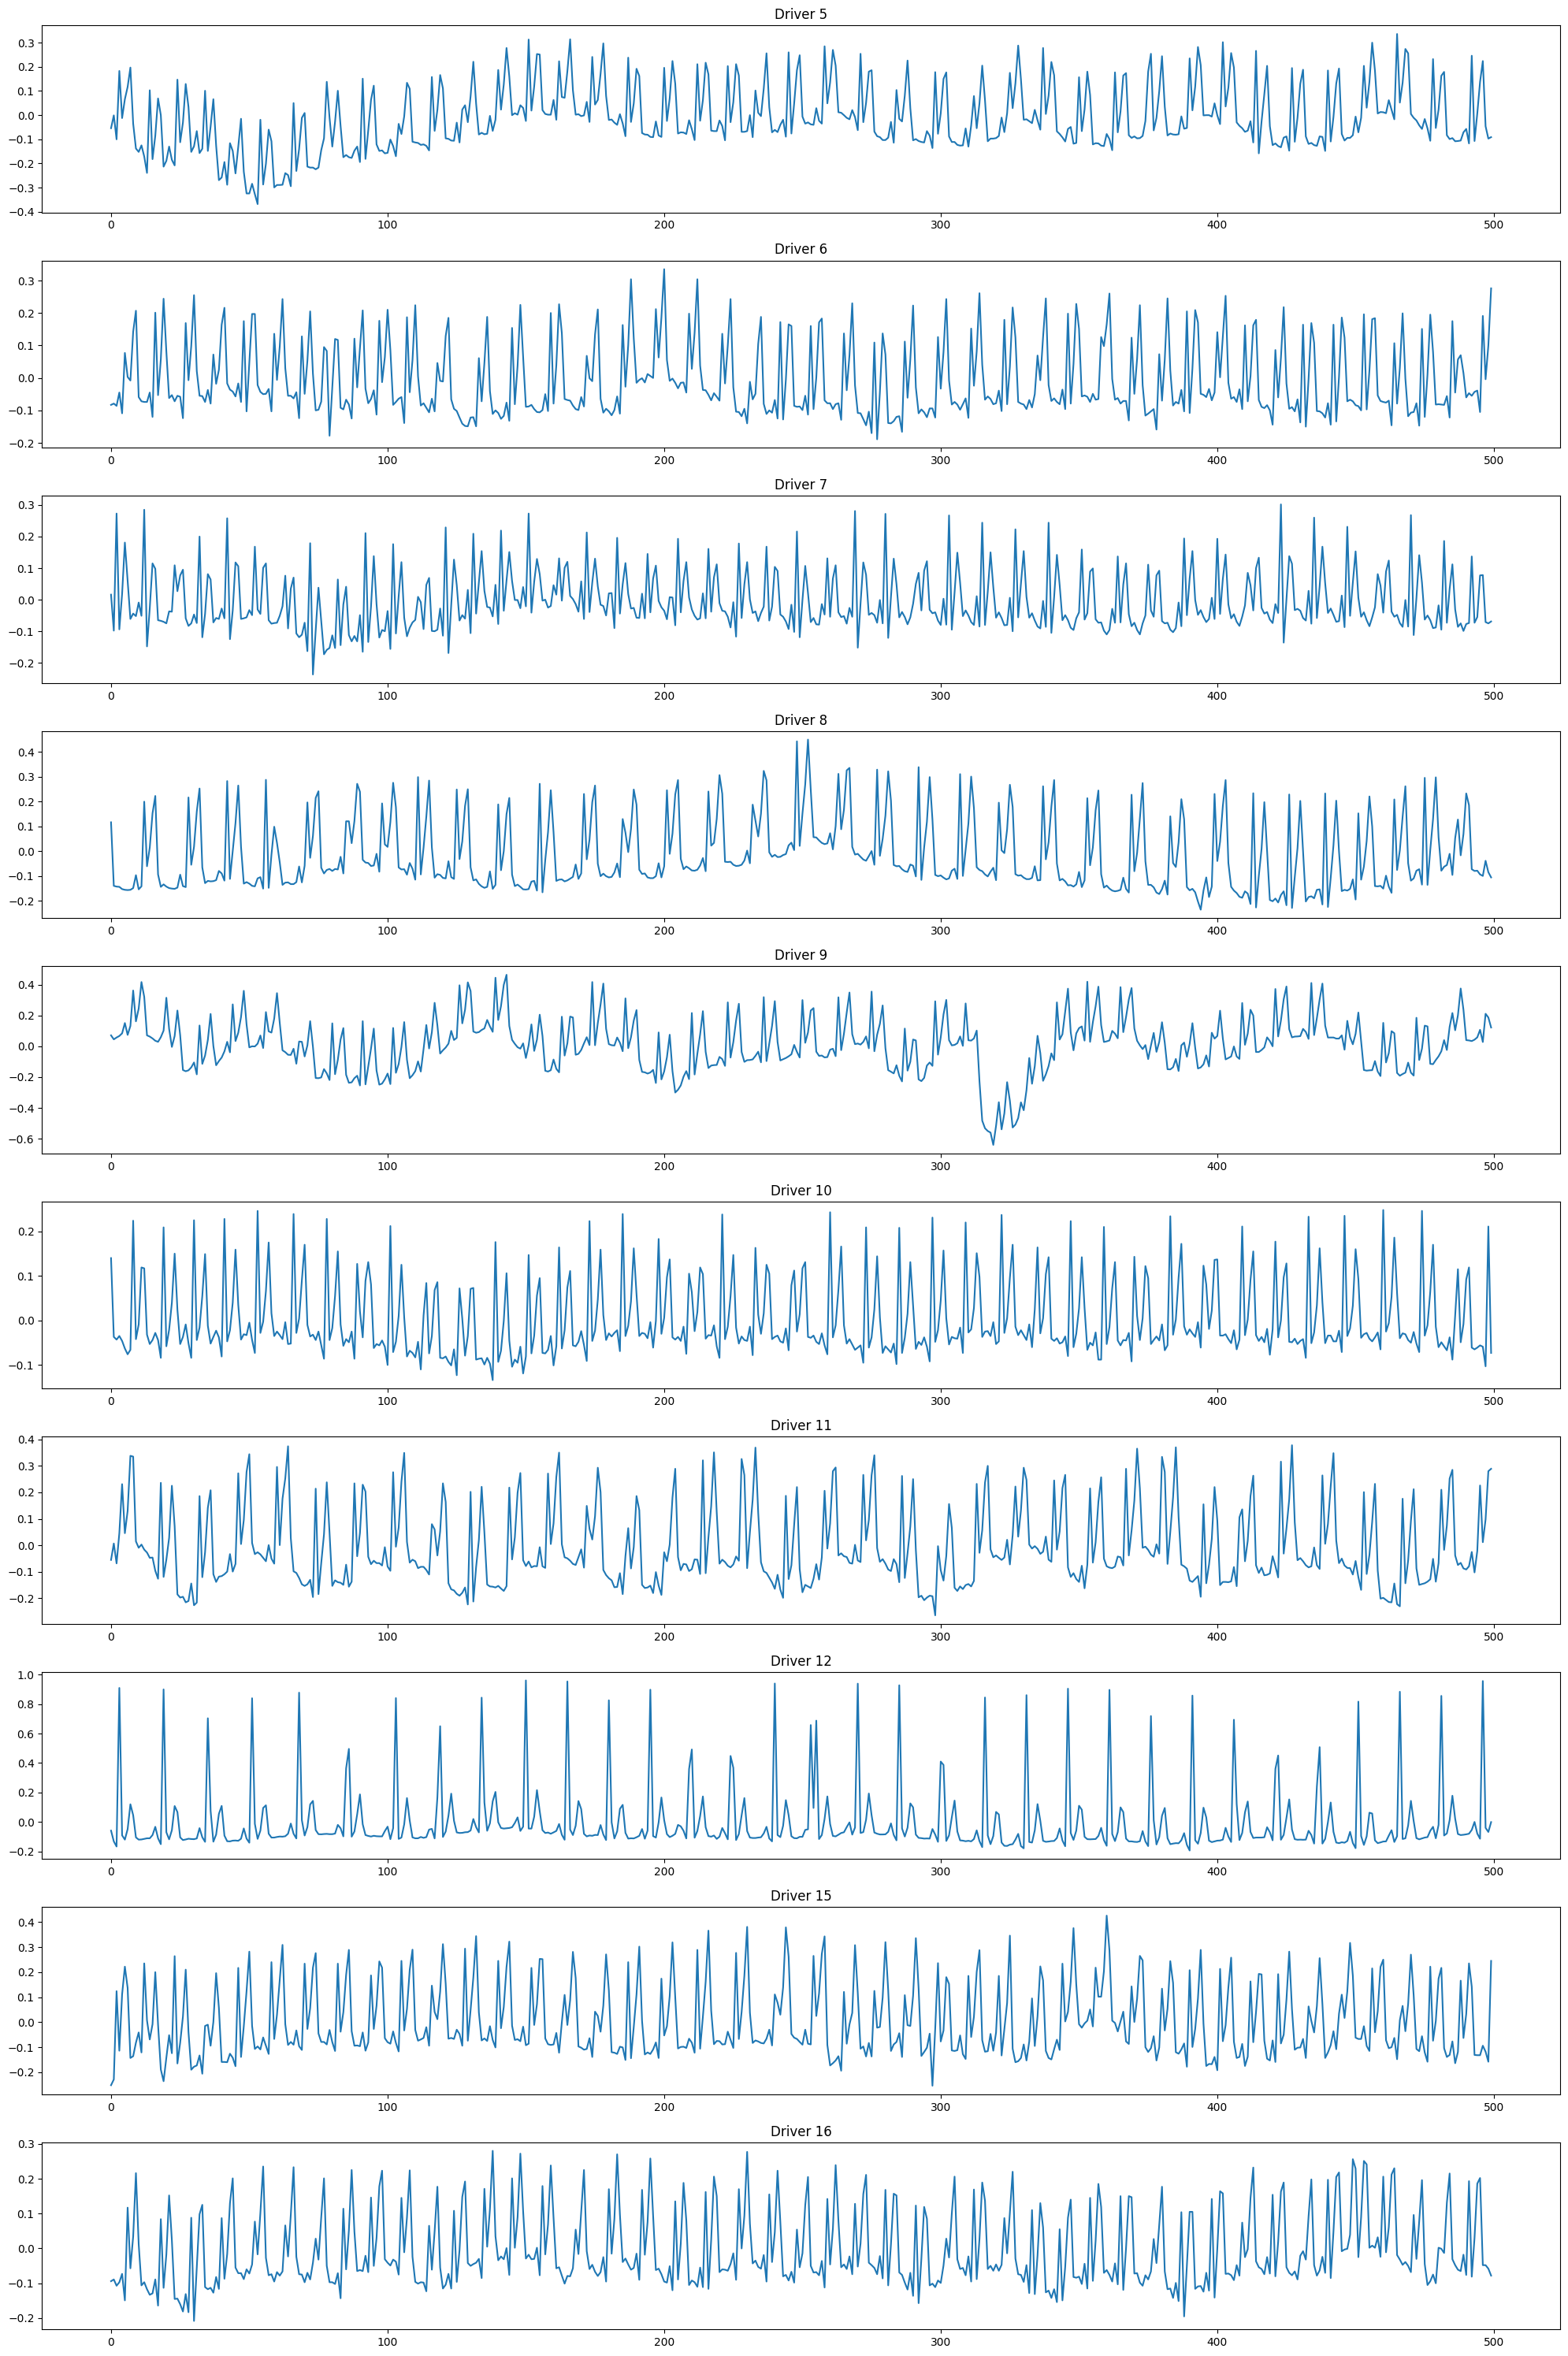

In [80]:
fig, ax = plt.subplots(
    len(drivers_sessions_info), 1, figsize=(20, 3 * len(drivers_sessions_info))
)
for i, driver_id in enumerate(drivers_sessions_info.keys()):
    ax[i].plot(records.get(driver_id).get("p_signal")[:500, 0])
    ax[i].set(title=f"Driver {driver_id}")
plt.tight_layout()

5 [28951 36150]
6 [27473 34281]
7 [29082 39275]
8 [25399 32123]
9 [32430 40308]
10 [28217 36271]
11 [28673 35583]
12 [26432 33463]
15 [25613 32347]
16 [28952 35593]


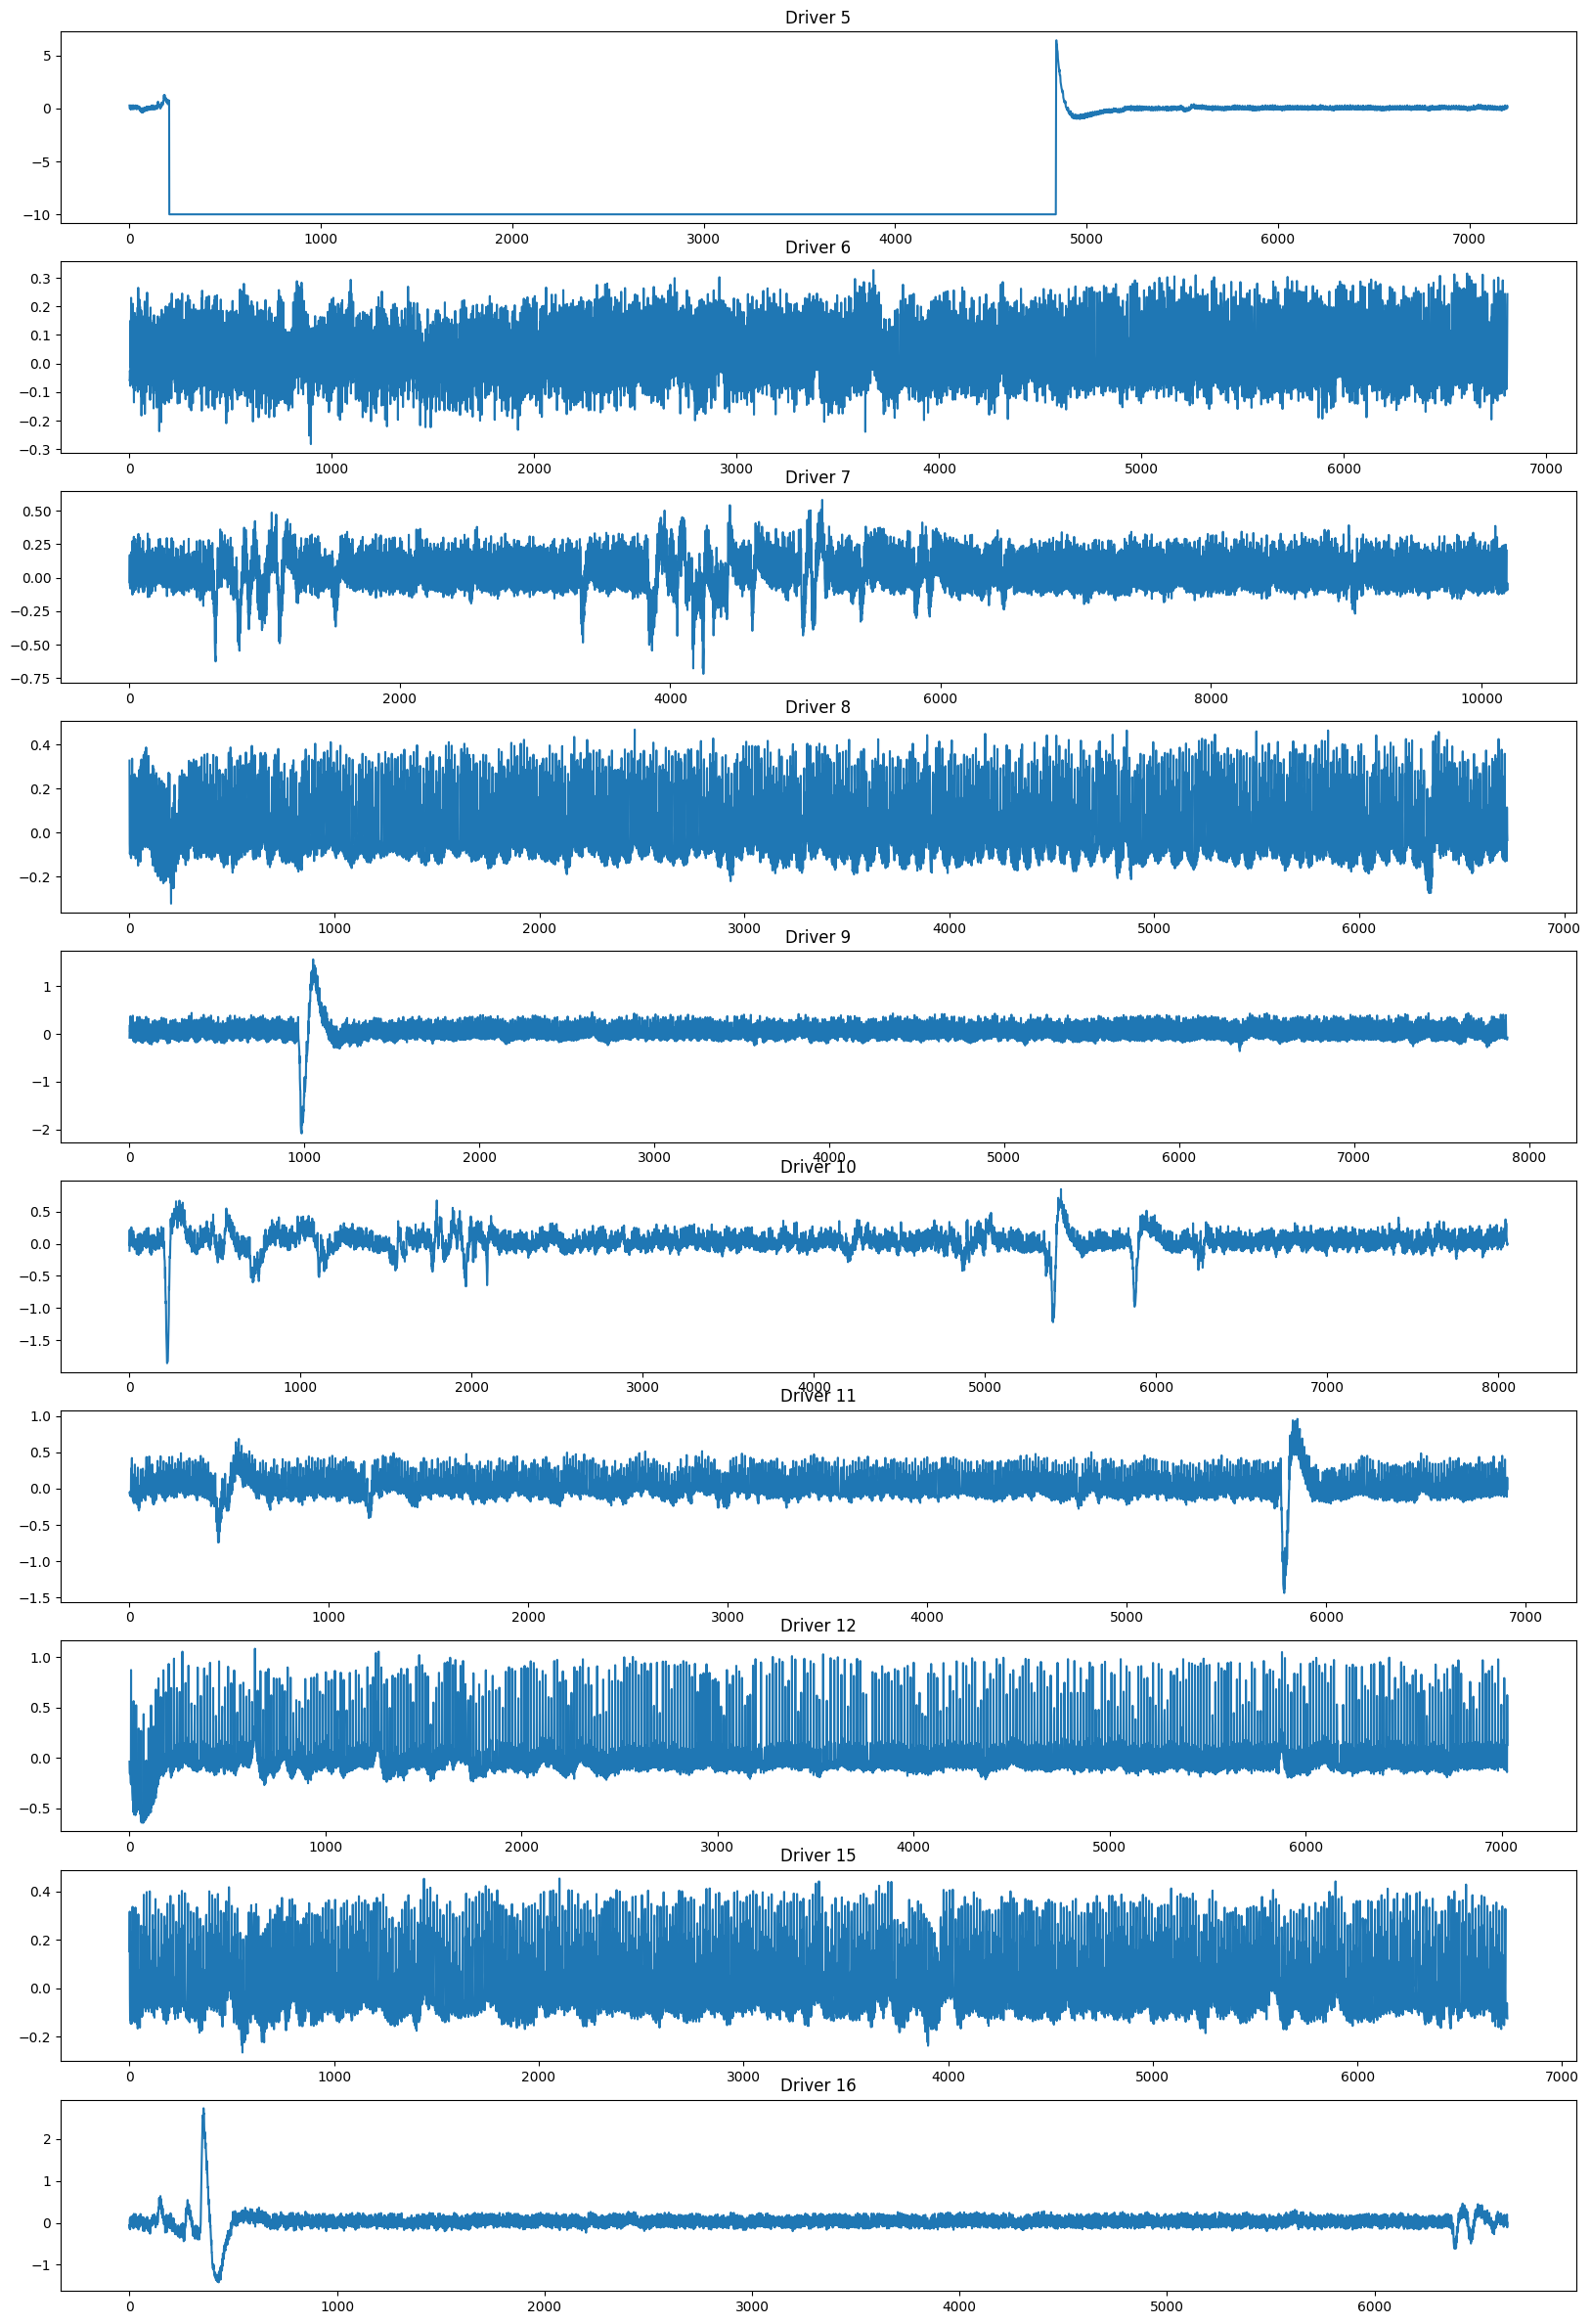

In [296]:
# wd, m = hp.process(record.get("p_signal")[28673:35583, 0], record.get("fs"))
fig, ax = plt.subplots(
    len(drivers_sessions_info), 1, figsize=(20, 3 * len(drivers_sessions_info))
)
for i, driver_id in enumerate(drivers_sessions_info.keys()):
    indices_of_subtasks = np.ceil(
        np.fromiter(drivers_sessions_info.get(driver_id).values(), dtype=float)
        * 15.5
        * 60
    ).astype(int)
    indices_of_subtasks[-1] = 0
    indices_of_subtasks = np.cumsum(np.roll(indices_of_subtasks, 1))
    print(driver_id, indices_of_subtasks)
    ax[i].plot(
        records.get(driver_id).get("p_signal")[
            indices_of_subtasks[0] : indices_of_subtasks[1], 0
        ]
    )
    ax[i].set(title=f"Driver {driver_id}")

---

## Split & Try learn

In [3]:
import torch

from torch.utils.data import Dataset, DataLoader

In [4]:
np.random.seed(1337)

In [5]:
with open(os.path.join("ds", "cleared_drivers_session_info.pkl"), "rb") as f:
    all_data = pickle.load(f)

In [21]:
# class Dataset:
#     def __init__(self, all_data, step=15, window_size=30, unify_stress=True):
#         self.all_data = all_data
#         self._drivers_datasets = {
#             driver_id: self._get_driver_dataset(driver_id, step, window_size, unify_stress)
#             for driver_id in all_data
#         }
#         self.__all_data = None
#
#     def _get_driver_dataset(self, u_id, step=15, window_size=30, unify_stress=True):
#         driver_data = all_data.get(u_id)
#
#         stress_labeled_data = []
#         for state_data in driver_data:
#             rr_list_corr = np.array(state_data.get("working_data").get("RR_list_cor"))
#             count = ((rr_list_corr.shape[0] - window_size)//step) + 1
#             iterable = (list(x * step + i for i in range(window_size)) for x in range(count))
#             indices = np.fromiter(iterable, dtype=np.dtype((int, window_size)))
#             stress_label = state_data.get("stress_label")
#             if unify_stress:
#                 stress_label = int(bool(stress_label))
#             stress_labeled_data.extend(zip(rr_list_corr.take(indices), [stress_label] * indices.shape[0]))
#         np.random.shuffle(stress_labeled_data)
#         return stress_labeled_data
#
#     def get_driver_dataset(self, u_id):
#         return self._drivers_datasets.get(u_id)
#
#     def __iter__(self):
#         self.__all_data = list(map(iter, self._drivers_datasets.values()))
#         print(self.__all_data)
#         return self
#
#     def __next__(self):
#         while len(self.__all_data):
#             driver_data = random.choice(self.__all_data)
#             try:
#                 return next(driver_data)
#             except StopIteration:
#                 self.__all_data.remove(driver_data)
#                 print("Raised stop iteration; len(data):", len(self.__all_data))
#                 continue
#         raise StopIteration()

In [ ]:
from ds.drivers.datasets import DriversDataset

In [6]:
def get_driver_train_test_items(
    input_data, step=15, window_size=30, unify_stress=True, test_percentage=0.2
):
    stress_labeled_data = []
    for state_data in input_data:
        rr_list_corr = np.array(
            state_data.get("working_data").get("RR_list_cor")
        )
        count = ((rr_list_corr.shape[0] - window_size) // step) + 1
        iterable = (
            list(x * step + i for i in range(window_size))
            for x in range(count)
        )
        indices = np.fromiter(iterable, dtype=np.dtype((int, window_size)))
        stress_label = state_data.get("stress_label")
        if unify_stress:
            stress_label = int(bool(stress_label))
        stress_labeled_data.extend(
            zip(rr_list_corr.take(indices), [stress_label] * indices.shape[0])
        )
    train_count = int(len(stress_labeled_data) * (1 - test_percentage))
    return stress_labeled_data[:train_count], stress_labeled_data[train_count:]

In [7]:
class DriversBaseDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        step,
        window_size,
        unify_stress,
        ds_type: str = "train",
        *args,
        **kwargs,
    ):
        super(DriversBaseDataset, self).__init__(*args, **kwargs)
        assert ds_type in ("train", "test")
        self.ds_type = ds_type
        self.step = step
        self.window_size = window_size
        self.unify_stress = unify_stress
        self._input_data = None
        self._train_items = None
        self._test_items = None

    def _set_items(self):
        self._items = (
            self._train_items if self.ds_type == "train" else self._test_items
        )

    def __len__(self):
        return len(self._items)

    def __getitem__(self, idx):
        _data, _label = self._items[idx]
        return torch.tensor(_data, dtype=torch.float32), _label

In [8]:
class DriverDataset(DriversBaseDataset):
    def __init__(
        self,
        driver_data,
        step=15,
        window_size=30,
        unify_stress=True,
        test_percentage=0.2,
        ds_type: str = "train",
        *args,
        **kwargs,
    ):
        super(DriverDataset, self).__init__(
            *args,
            ds_type=ds_type,
            step=step,
            window_size=window_size,
            unify_stress=unify_stress,
            **kwargs,
        )
        self._train_items, self._test_items = get_driver_train_test_items(
            driver_data, step, window_size, unify_stress, test_percentage
        )
        self._set_items()

In [9]:
class DriversDataset(DriversBaseDataset):
    def __init__(
        self,
        drivers_data,
        step=15,
        window_size=30,
        unify_stress=True,
        test_percentage=0.2,
        ds_type: str = "train",
        *args,
        **kwargs,
    ):
        super(DriversDataset, self).__init__(
            *args,
            ds_type=ds_type,
            step=step,
            window_size=window_size,
            unify_stress=unify_stress,
            **kwargs,
        )
        self._train_items = []
        self._test_items = []
        for driver_data in drivers_data.values():
            train_data, test_data = get_driver_train_test_items(
                driver_data, step, window_size, unify_stress, test_percentage
            )
            self._train_items.extend(train_data)
            self._test_items.extend(test_data)
        self._set_items()

In [18]:
ds_5 = DriverDataset(all_data.get(5))

In [10]:
ds_all_train = DriversDataset(all_data, ds_type="train")
ds_all_test = DriversDataset(all_data, ds_type="test")

In [11]:
dl_train = DataLoader(
    ds_all_train,
    batch_size=2,
    shuffle=True,
    num_workers=1,
    pin_memory=False,
    drop_last=True,
)

In [31]:
for i, (data, labels) in enumerate(dl_train):
    if i < 2:
        print(i, data, labels, data.shape, labels.shape)
    else:
        break

0 tensor([[516.1290, 580.6451, 580.6451, 580.6451, 580.6451, 580.6451, 580.6451,
         645.1613, 645.1613, 580.6451, 645.1613, 580.6451, 645.1613, 580.6451,
         580.6451, 645.1613, 645.1613, 451.6129, 645.1613, 709.6774, 645.1613,
         709.6774, 709.6774, 774.1935, 709.6774, 645.1613, 645.1613, 774.1935,
         709.6774, 774.1935],
        [387.0968, 193.5484, 580.6451, 193.5484, 580.6451, 387.0968, 193.5484,
         387.0968, 516.1290, 193.5484, 387.0968, 516.1290, 129.0323, 387.0968,
         129.0323, 387.0968, 129.0323, 516.1290, 516.1290, 516.1290, 387.0968,
         193.5484, 516.1290, 580.6451, 193.5484, 451.6129, 193.5484, 645.1613,
         387.0968, 129.0323]]) tensor([1, 1]) torch.Size([2, 30]) torch.Size([2])
1 tensor([[516.1290, 387.0968, 129.0323, 580.6451, 580.6451, 193.5484, 451.6129,
         193.5484, 516.1290, 322.5807, 193.5484, 645.1613, 516.1290, 387.0968,
         193.5484, 322.5807, 193.5484, 387.0968, 193.5484, 322.5807, 193.5484,
         451.61

In [12]:
import torch.nn as nn
import torch.optim as optim

# from torchsummary import summary

In [13]:
class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        in_ch = 1
        out_ch = 5
        self.conv0 = nn.Conv1d(
            in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn0 = nn.BatchNorm1d(out_ch)
        self.relu0 = nn.ReLU(inplace=True)
        in_ch = out_ch
        out_ch = 10
        self.conv1 = nn.Conv1d(
            in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm1d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)

        self.fc0 = nn.Linear(10 * 30, 100)
        # self.fc0 = nn.Linear(5 * 30, 100)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(100, 10)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.relu0(self.bn0(self.conv0(x)))
        x = self.relu1(self.bn1(self.conv1(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.fc0(x)
        x = self.relu2(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
net = TestModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [15]:
min_loss = np.inf
epoch_count = 50

In [16]:
for epoch in range(epoch_count):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dl_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.unsqueeze(inputs, 1).to(torch.float32)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print_step = 50
        if i % print_step == print_step - 1:
            mean_loss = running_loss / print_step
            min_loss = min(mean_loss, min_loss)
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {mean_loss:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,    50] loss: 0.551
[1,   100] loss: 0.546
[1,   150] loss: 0.561
[1,   200] loss: 0.548
[1,   250] loss: 0.564
[1,   300] loss: 0.523
[1,   350] loss: 0.522
[1,   400] loss: 0.612
[1,   450] loss: 0.596
[1,   500] loss: 0.454
[1,   550] loss: 0.672
[1,   600] loss: 0.541
[1,   650] loss: 0.602
[1,   700] loss: 0.568
[1,   750] loss: 0.585
[1,   800] loss: 0.595
[1,   850] loss: 0.464
[1,   900] loss: 0.641
[1,   950] loss: 0.568
[1,  1000] loss: 0.614
[1,  1050] loss: 0.587
[1,  1100] loss: 0.614
[1,  1150] loss: 0.503
[1,  1200] loss: 0.550
[1,  1250] loss: 0.471
[2,    50] loss: 0.543
[2,   100] loss: 0.516
[2,   150] loss: 0.517
[2,   200] loss: 0.508
[2,   250] loss: 0.528
[2,   300] loss: 0.495
[2,   350] loss: 0.497
[2,   400] loss: 0.528
[2,   450] loss: 0.604
[2,   500] loss: 0.507
[2,   550] loss: 0.595
[2,   600] loss: 0.571
[2,   650] loss: 0.512
[2,   700] loss: 0.555
[2,   750] loss: 0.510
[2,   800] loss: 0.442
[2,   850] loss: 0.557
[2,   900] loss: 0.666
[2,   950] 

In [51]:
with torch.no_grad():
    d = torch.rand(10, 1, 30)
    print(d.shape)
    r = net(d)

torch.Size([10, 1, 30])


tensor([[  2.3907,   2.7667],
        [-16.2854,  23.8085],
        [-11.5308,  17.0269],
        [ -3.7384,  10.1310],
        [-22.1391,  32.5404],
        [-10.2340,  16.7295],
        [-13.3582,  19.9191],
        [-21.1040,  30.2378],
        [-18.9796,  26.9438],
        [-14.8214,  22.3936]])

In [52]:
nn.Softmax(1)(r).max(1).indices

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])